# ACTIVE OPTICS CONTROL

In [1]:
import numpy as np
import numpy.linalg as LA
import ceo
import matplotlib.pyplot as plt
import json
import sys
import time
import ubjson
from IPython.display import display, clear_output
%matplotlib inline
reload(ceo)

<module 'ceo' from '/home/ubuntu/CEO/python/ceo/__init__.pyc'>

## Simulation sampling time, WFSs exposure and simulation duration [s]

In [2]:
samplingTime = 1/200.0
wfsExposureTime = 15
simDuration = 15*5+1
wfsDelay = 1

# PARAMETERS

* Pupil size

In [3]:
pupil_size = 25.5

- atmosphere or not

In [4]:
WITH_ATMOSPHERE = False

* diffractive or geometric TT7

In [5]:
TT7_CLASS = "TT7" # diffractive model
#TT7_CLASS = "GeometricTT7" # geometric model

 - initial segments misalignment or not

In [6]:
WITH_MISALIGNMENT = False
if WITH_MISALIGNMENT:
    TT7_CLASS = "GeometricTT7"

## GMT

In [7]:
gmt_prms = {'M1_mirror_modes':u"bending modes",'M1_N_MODE':42}

## Optical paths

### On-axis imager

In [8]:
if WITH_ATMOSPHERE:
    on_axis_imgr = {'N_SIDE_LENSLET':1,"N_PX_PUPIL":511,
                   'N_PX_IMAGE':1001,'intensityThreshold':0.0}
else:
    on_axis_imgr = {'N_SIDE_LENSLET':1,"N_PX_PUPIL":255,
                   'DFT_osf':4,'N_PX_IMAGE':401,'intensityThreshold':0.0}    
on_axis_src = {'photometric_band':"V",'zenith':[0],'azimuth':[0],
               'fwhm':0,'magnitude':0,'rays_box_size':pupil_size,
               'rays_box_sampling':on_axis_imgr['N_PX_PUPIL']+1,'rays_origin':[0,0,25],
               'samplingTime':samplingTime}

### WFSs

In [9]:
import csv
_asterism_zenith = []
_asterism_azimuth = []
_asterism_magnitude = []
with open('asterisms_agws', 'rb') as csvfile:
    asterisms = csv.reader(csvfile)
    for row in asterisms:
        _asterism_zenith.append( float(row[0])*ceo.constants.ARCMIN2RAD )
        _asterism_azimuth.append( float(row[1]) )
        _asterism_magnitude.append( float(row[2]) )

asterism_id = np.load('asterism_id.npy')
print "Asterism ID: %d"%asterism_id

asterism_zenith = _asterism_zenith[asterism_id*4:(1+asterism_id)*4]
asterism_azimuth = _asterism_azimuth[asterism_id*4:(1+asterism_id)*4]
asterism_magnitude = _asterism_magnitude[asterism_id*4:(1+asterism_id)*4]

asterism_zenith,asterism_azimuth,asterism_magnitude = \
    zip(*sorted(zip(asterism_zenith,asterism_azimuth,asterism_magnitude),reverse=True))

Asterism ID: 24


In [10]:
#asterism_id = 40
asterism_id += 1
np.save('asterism_id',asterism_id)

In [11]:
wfs_nLenslet = 48
wfs_prms = {'N_SIDE_LENSLET':wfs_nLenslet,"N_PX_LENSLET":16,'d':pupil_size/wfs_nLenslet,
           'DFT_osf':2,'N_PX_IMAGE':24,'BIN_IMAGE':3,'N_GS': 3,
           'readOutNoiseRms':0.5,'noiseFactor':np.sqrt(2),
           'photoElectronGain':0.63, 'exposureTime':wfsExposureTime,
           'intensityThreshold':0.0}

zen = np.ones(3)*ceo.constants.ARCMIN2RAD*6
azi = np.arange(3)*2*np.pi/3
wfs_guide_stars = {'photometric_band':"R+I",'zenith':asterism_zenith[:3],
                   'azimuth':asterism_azimuth[:3],
                   'fwhm':0,'magnitude':asterism_magnitude[:3],'rays_box_size':pupil_size,
                   'rays_box_sampling':wfs_prms['N_SIDE_LENSLET']*wfs_prms['N_PX_LENSLET']+1,
                   'rays_origin':[0,0,25],'samplingTime':samplingTime}

### TT7

In [12]:
tt7_prms = {"N_PX_LENSLET":1023,'d':pupil_size,
           'N_PX_IMAGE':142*5,'BIN_IMAGE':142,
            'readOutNoiseRms':0.5,'photoElectronGain':0.66,
            'exposureTime':samplingTime,'intensityThreshold':0.0}

zen = ceo.constants.ARCMIN2RAD*6
azi = np.pi
tt7_guide_star = {'photometric_band':"R+I",'zenith':asterism_zenith[-1],
                  'azimuth':asterism_azimuth[-1],
                  'fwhm':0,'magnitude':asterism_magnitude[-1],'rays_box_size':pupil_size,
                  'rays_box_sampling':tt7_prms['N_PX_LENSLET']+1,'rays_origin':[0,0,25],
                  'samplingTime':samplingTime}

## Atmosphere

In [13]:
r0 = 12.8e-2 
r0_wavelength = 500e-9
if WITH_ATMOSPHERE:
    atm_prms = dict(jsonfile='/mnt/bins/gmtAtmosphereL060.json',
                    zipdata='s3://gmto.rconan/gmtAtmosphereL060.zip',
                    cache='/mnt/bins/')
else:
    atm_prms = {}

## JSON parameter files

In [14]:
config = {'GMT':gmt_prms, 
          'ON_AXIS_SRC':on_axis_src, 'ON_AXIS_IMGR':on_axis_imgr,
          'WFS_GUIDE_STARS': wfs_guide_stars, 'WFS':wfs_prms,
          'TT7_GUIDE_STAR': tt7_guide_star, 'TT7':tt7_prms,
          'ATMOSPHERE':atm_prms}

In [15]:
for key in config:
    with open('AcO_'+key+'.json', 'w') as outfile:
        print ">>> "+outfile.name
        json.dump(config[key], outfile, sort_keys = False, indent = 4, ensure_ascii=False)        
    with open('AcO_'+key+'.ubj', 'w') as outfile:
        print ">>> "+outfile.name
        ubjson.dump(config[key], outfile)

>>> AcO_ON_AXIS_SRC.json
>>> AcO_ON_AXIS_SRC.ubj
>>> AcO_ATMOSPHERE.json
>>> AcO_ATMOSPHERE.ubj
>>> AcO_WFS_GUIDE_STARS.json
>>> AcO_WFS_GUIDE_STARS.ubj
>>> AcO_WFS.json
>>> AcO_WFS.ubj
>>> AcO_ON_AXIS_IMGR.json
>>> AcO_ON_AXIS_IMGR.ubj
>>> AcO_TT7_GUIDE_STAR.json
>>> AcO_TT7_GUIDE_STAR.ubj
>>> AcO_TT7.json
>>> AcO_TT7.ubj
>>> AcO_GMT.json
>>> AcO_GMT.ubj


# OBJECT DEFINITIONS

In [16]:
gmt = ceo.GMT_MX(**gmt_prms)

In [17]:
gs0 = ceo.Source(**on_axis_src)
imgr = ceo.Imaging(**on_axis_imgr)

In [18]:
gs = ceo.Source(**wfs_guide_stars)
wfs = ceo.ShackHartmann(**wfs_prms)

In [19]:
tt7_gs = ceo.Source(**tt7_guide_star)
if TT7_CLASS=='TT7':
    tt7 = ceo.TT7(**tt7_prms)
if TT7_CLASS=='GeometricTT7':
    tt7 = ceo.GeometricTT7()

In [20]:
if WITH_ATMOSPHERE:
    atm = ceo.JGmtAtmosphere(**atm_prms)
    atm.r0 = r0
    gs0.timeStamp = 0
    gs0>>(atm,)
    +gs0
    plt.imshow(gs0.phase.host(units='nm'),interpolation='none',cmap='viridis')
    plt.colorbar()
else:
    atm = None

## GUIDE STARS

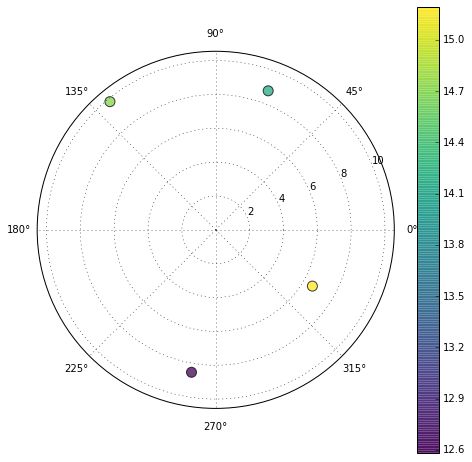

In [21]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111,polar=True)
zen = np.concatenate([gs.zenith,tt7_gs.zenith])*ceo.constants.RAD2ARCMIN
azi = np.concatenate([gs.azimuth,tt7_gs.azimuth])
mag = np.concatenate([gs.magnitude,tt7_gs.magnitude])
c = ax.scatter(azi,zen,c=mag,s=100,cmap=plt.cm.viridis)
c.set_alpha(0.75)
#c.set_edgecolor('None')
plt.colorbar(c,ax=ax)

# CALIBRATION

## WFSs

Seeing conversion to FWHM in detector pixel (before binning):

In [22]:
_r0_ = r0*(gs.wavelength/r0_wavelength)**1.2
seeingArcsec = gs.wavelength/_r0_*ceo.constants.RAD2ARCSEC
print "WFS seeing: %.2farcsec"%seeingArcsec
gs_fwhm = round(seeingArcsec/(wfs.camera.pixelScaleArcsec(gs)/wfs.BIN_IMAGE))
print "WFS FWHM: %d pixel"%gs_fwhm
gs.fwhm = gs_fwhm

WFS seeing: 0.75arcsec
WFS FWHM: 5 pixel


### Reference slopes

In [23]:
gs.reset()
gmt.reset()
gmt.propagate(gs)
wfs.calibrate(gs,0.)
print wfs.n_valid_lenslet

6912


In [24]:
print "detector resolution: %dpixel"%wfs.N_PX_FRAME
print "WFS pixel scale:  %.2farcsec"%wfs.pixel_scale_arcsec
print "WFS field-of-view %.2farcsec"%(wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/wfs.BIN_IMAGE)

detector resolution: 384pixel
WFS pixel scale:  0.42arcsec
WFS field-of-view 3.33arcsec


###  Interaction matrix (decoupled)

In [25]:
%%time
gwfs = ceo.GeometricShackHartmann(48,25.5/48,N_GS=gs.N_SRC)
gs.reset()
gmt.reset()
gmt.propagate(gs)
gwfs.calibrate(gs,0.)

C = gmt.AGWS_calibrate(gwfs,gs,decoupled=True,fluxThreshold=0.5,
                      calibrationVaultKwargs={'nThreshold':[2]*6+[0],
                                              'insertZeros':[None]*6 + [[2,4,6]]})

___ M1 ___ (Rxyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M2 ___ (Rxyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M1 ___ (Txyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M2 ___ (Txyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M1 ___ (bending modes)
Segment #0: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
Segment #1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
Segment #2: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
Segment #3: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
Segment #4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
Segment #5: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 

The following cell allows to save and to load the WFS interaction matrix

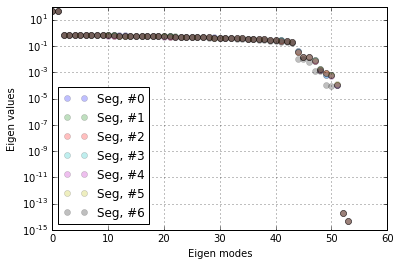

In [26]:
for k in range(7):
    plt.semilogy(C.eigenValues[k],'o',alpha=0.25,label='Seg, #%d'%k)
plt.grid()
plt.legend(loc=0)
plt.xlabel('Eigen modes')
plt.ylabel('Eigen values')

## TT7

Seeing conversion to FWHM in detector pixel (before binning):

In [26]:
if TT7_CLASS=='TT7':
    _r0_ = r0*(tt7_gs.wavelength/r0_wavelength)**1.2
    seeingArcsec = tt7_gs.wavelength/_r0_*ceo.constants.RAD2ARCSEC
    print "TT7 seeing: %.2farcsec"%seeingArcsec
    pxscl = tt7.camera.pixelScaleArcsec(tt7_gs)
    tt7_gs_fwhm = round(seeingArcsec/(pxscl/tt7.BIN_IMAGE))
    print "WFS FWHM: %d pixel"%tt7_gs_fwhm
    tt7_gs.fwhm = tt7_gs_fwhm

    print "detector resolution: %dpixel"%tt7.N_PX_FRAME
    print "WFS pixel scale:  %.2farcsec"%pxscl
    print "WFS field-of-view %.2farcsec"%(pxscl*tt7.N_PX_IMAGE/tt7.BIN_IMAGE)

TT7 seeing: 0.75arcsec
WFS FWHM: 259 pixel
detector resolution: 5pixel
WFS pixel scale:  0.41arcsec
WFS field-of-view 2.05arcsec


### Reference slopes

In [27]:
tt7_gs.reset()
gmt.reset()
gmt.propagate(tt7_gs)
tt7.reset()
tt7.calibrate(tt7_gs)

### Interaction matrix

In [28]:
%%time
Dtt7 = gmt.calibrate(tt7,tt7_gs,mirror = 'M2',mode='segment tip-tilt',stroke=1e-6)
print Dtt7.shape
print LA.cond(Dtt7)
Mtt7 = LA.inv(Dtt7)

___ M2 ___ (segment tip-tilt)
Segment #:1 2 3 4 5 6 7 
------------
(14, 14)
1.03712177276
CPU times: user 4.47 s, sys: 2.66 s, total: 7.13 s
Wall time: 7.12 s


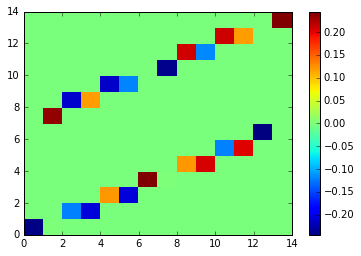

In [29]:
plt.pcolor(Dtt7)
plt.colorbar()

# ON AXIS IMAGER

OPTICAL PATH: ['GMT_MX', 'Imaging']
detector resolution: 401pixel
WFS pixel scale:  1.11mas
WFS field-of-view 0.45arcsec
EE80: 26.69mas


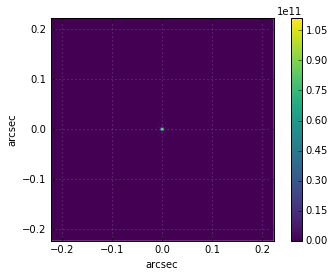

In [38]:
gs0>>(gmt,imgr)
~gmt
~imgr
+gs0
print "detector resolution: %dpixel"%imgr.N_PX_FRAME
print "WFS pixel scale:  %.2fmas"%(imgr.pixelScaleArcsec(gs0)*1e3)
print "WFS field-of-view %.2farcsec"%(imgr.pixelScaleArcsec(gs0)*imgr.N_PX_IMAGE/imgr.BIN_IMAGE)
ext = np.array([-1,1,-1,1])*imgr.N_PX_FRAME*0.5*imgr.pixelScaleArcsec(gs0)
plt.imshow(imgr.frame.host(),interpolation='None',cmap='viridis',extent=ext)
plt.colorbar()
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.grid(color='w',linestyle=':',alpha=0.5)
ee80_0 = imgr.ee80(units=1e3*imgr.pixelScaleArcsec(gs0))
print "EE80: %.2fmas"%ee80_0

OPTICAL PATH: ['GMT_MX', 'Imaging']
detector resolution: 401pixel
WFS pixel scale:  1.11mas
WFS field-of-view 0.45arcsec
EE80: 26.69mas


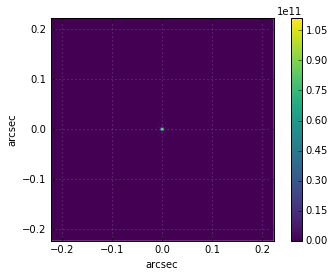

In [40]:
gs0>>(gmt,imgr)
~gmt
~imgr
+gs0
+imgr
print "detector resolution: %dpixel"%imgr.N_PX_FRAME
print "WFS pixel scale:  %.2fmas"%(imgr.pixelScaleArcsec(gs0)*1e3)
print "WFS field-of-view %.2farcsec"%(imgr.pixelScaleArcsec(gs0)*imgr.N_PX_IMAGE/imgr.BIN_IMAGE)
ext = np.array([-1,1,-1,1])*imgr.N_PX_FRAME*0.5*imgr.pixelScaleArcsec(gs0)
plt.imshow(imgr.ghost_frame,interpolation='None',cmap='viridis',extent=ext)
plt.colorbar()
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.grid(color='w',linestyle=':',alpha=0.5)
ee80_0 = imgr.ee80(units=1e3*imgr.pixelScaleArcsec(gs0),from_ghost=True)
print "EE80: %.2fmas"%ee80_0

# AGWS CLOSED-LOOP

In [58]:
def updateGMT(__c__,_dist_,__tt7_c__=0.0):
    _s_ = np.s_[:]
    l = 12+gmt.M1.modes.n_mode
    cp = np.reshape(__c__,(7,l))
    gmt.M1.motion_CS.update(Rxyz=(_s_,_s_,_dist_[0] - cp[:,:3]),
                            Txyz=(_s_,_s_,_dist_[2] - cp[:,3:6]))
    gmt.M2.motion_CS.update(Rxyz=(_s_,_s_,_dist_[1] - __tt7_c__ - cp[:,6:9]),
                            Txyz=(_s_,_s_,_dist_[3] - cp[:,9:12]))
    gmt.M1.modes.a[:] = _dist_[4] - cp[:,12:]
    gmt.M1.modes.update()

In [59]:
from numpy.random import randn
def perturbations():
    M1_Txyz0      = randn(7,3)*75e-6;
    M1_Txyz0[:,2] = randn(7)*160e-6;
    M1_Txyz0[6,2] = 0; #% M1 S1 Tz

    M2_Txyz0      = randn(7,3)*75e-6;
    M2_Txyz0[:,2] = randn(7)*170e-6;

    arcs2rad = np.pi/180/3600;
    M1_Rxyz0      = randn(7,3)*0.38*arcs2rad;
    M1_Rxyz0[:,2] = randn(7)*40*arcs2rad;

    M2_Rxyz0      = randn(7,3)*3.0*arcs2rad;
    M2_Rxyz0[:,2] = randn(7)*330*arcs2rad;

    #M1_RiBo_d = M1_Txyz0 M1_Rxyz0]; 
    #M2_RiBo_d = [M2_Txyz0 M2_Rxyz0];

    radialOrders = np.concatenate( [np.ones((1,x+1))*x for x in range(9)] , axis=1 )
    scale = 1.0/radialOrders[0,3:];
    M1_BeMo_d = 1e-6*randn(7,gmt.M1.modes.n_mode)*scale[None,:]/scale[0];
    
    return (M1_Rxyz0,M2_Rxyz0,M1_Txyz0,M2_Txyz0,M1_BeMo_d)

In [61]:
nStep = int(simDuration/samplingTime)
nFrame = int(wfsExposureTime/samplingTime)
nWfsDelay = int(wfsDelay/samplingTime)

## Reference PSF

In [ ]:
%%time
if WITH_ATMOSPHERE:
    ps0_rms_0 = np.zeros(nStep)
    gmt0 = ceo.GMT_MX()
    ~imgr
    gs0>>(atm,gmt0,imgr)
    gs0.timeStamp = 0
    gs0.samplingTime = samplingTime
    for k in range(nStep):
        +gs0
        ps0_rms_0[k] = gs0.wavefront.rms(-9)
        if (k<nWfsDelay):
            ~imgr

    psf_atm_0 = imgr.frame.host()
    ee80_atm_0 = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()
    print "EE80: %.2fmas"%ee80_atm_0
    

    fig, (ax1,ax2) = plt.subplots(ncols=2)
    fig.set_size_inches(14,6)
    frame = imgr.frame.host()
    h1= ax1.imshow(frame,interpolation='None',cmap='viridis',extent=ext)
    plt.colorbar(h1,ax=ax1)
    ax1.grid(color='w',linestyle=':',alpha=0.5)
    ax1.set_xlabel('arcsec')
    ax1.set_ylabel('arcsec')
    
    ax2.plot(np.linspace(-1,1,imgr.N_PX_FRAME)*imgr.pixelScaleArcsec(gs0)*imgr.N_PX_FRAME*0.5,frame[500,:],alpha=0.5)
    ax2.plot(np.linspace(-1,1,imgr.N_PX_FRAME)*imgr.pixelScaleArcsec(gs0)*imgr.N_PX_FRAME*0.5,frame[:,500],alpha=0.5)
    ax2.grid()
    ax2.set_xlabel('arcsec')
    print "Guide star time stamp:%gs"%gs0.timeStamp

## Setting the optical paths

In [65]:
~gmt
~wfs
~imgr
~gs0
~gs
~tt7_gs
if WITH_ATMOSPHERE:
    gs0>>(atm,gmt,imgr)
    
    gs.fwhm = 0
    gs>>(atm,gmt,wfs)
    
    tt7_gs.fwhm = 0
    tt7_gs>>(atm,gmt,tt7)
else:
    gs0>>(gmt,imgr)
    
    gs.fwhm = gs_fwhm
    gs>>(gmt,wfs)    
    
    if TT7_CLASS=='TT7':
        tt7_gs.fwhm = tt7_gs_fwhm
        tt7_gs>>(gmt,tt7)
    if TT7_CLASS=='GeometricTT7':
        tt7_gs>>(gmt,tt7,)

OPTICAL PATH: ['JGmtAtmosphere', 'GMT_MX', 'Imaging']
OPTICAL PATH: ['JGmtAtmosphere', 'GMT_MX', 'ShackHartmann']
OPTICAL PATH: ['JGmtAtmosphere', 'GMT_MX', 'TT7']


## Setting the # of background photons

In [66]:
backgroundMagnitude = 16.8 # per arcsec^2, 30 deg. from full moon
#backgroundMagnitude = 19.7 # per arcsec^2, 60 deg. from full moon
+gs
wfs.camera.nBackgroundPhoton = gs.nBackgroundPhoton(backgroundMagnitude)*wfs.camera.pixelScaleArcsec(gs)**2
print "WFS # of background photon per frame: %.0f"%wfs.camera.nBackgroundPhoton
if TT7_CLASS=="TT7":
    +tt7_gs
    tt7.camera.nBackgroundPhoton = tt7_gs.nBackgroundPhoton(backgroundMagnitude)*tt7.camera.pixelScaleArcsec(tt7_gs)**2
    print "TT7 # of background photon per frame: %.0f"%tt7.camera.nBackgroundPhoton

WFS # of background photon per frame: 270726
TT7 # of background photon per frame: 264529


## Segments initial perturbations:

In [67]:
if WITH_MISALIGNMENT:
    dist = perturbations()
else:
    dist = [np.zeros((7,3)) for k in range(4)] + [np.zeros((7,42))]

In [68]:
gmt.reset()
gmt.M1.motion_CS.euler_angles[:] = dist[0]
gmt.M1.motion_CS.origin[:]       = dist[2]
gmt.M1.motion_CS.update()
gmt.M2.motion_CS.euler_angles[:] = dist[1]
gmt.M2.motion_CS.origin[:]       = dist[3]
gmt.M2.motion_CS.update()
gmt.M1.modes.a[:] = dist[4]
gmt.M1.modes.update()

### Initial WFE RMS [nm]:

In [69]:
gs0.timeStamp = 0
+gs0
print gs0.wavefront.rms(-9)

[ 3238.35934068]


## Integrator gains

In [70]:
wfs_loop_gain = 0.2
tt7_loop_gain = 0.2

## Number of sensor frame delays

In [71]:
wfs_nFrameDelay = 1
tt7_nFrameDelay = 1

In [72]:
VISU = False

In [81]:
%%time
print time.asctime( time.localtime(time.time()) )

gs0.timeStamp = 0
gs.timeStamp = 0
tt7_gs.timeStamp = 0
gs.samplingTime = samplingTime
gs0.samplingTime = samplingTime
tt7_gs.samplingTime = samplingTime

wfs.camera.exposureTime = wfsExposureTime
tt7.camera.exposureTime = samplingTime

print "nStep=%d ; nFrame=%d ; nWfsDelay=%d"%(nStep,nFrame,nWfsDelay)

ps0_rms = np.zeros(nStep)
ps0_seg_rms = np.zeros((nStep,7))
ps0_seg_piston = np.zeros((nStep,7))
bmc = np.zeros((nStep,7,gmt.M1.modes.n_mode))

tt7_c = np.zeros(14)
tt7_c_eps = np.zeros((14,1+tt7_nFrameDelay))
l = 12+gmt.M1.modes.n_mode
c = np.zeros((7*l,1))
c_eps = np.zeros((7*l,1+wfs_nFrameDelay))

tt7_stt = []
stt = np.zeros((nStep,14))
gtt = np.zeros((nStep,2))

gmt.M2.motion_CS.log = 0
~imgr
~wfs

if VISU:
    fig,(ax1,ax2) = plt.subplots(ncols=2)
    fig.set_size_inches(15,6)

for k in range(nStep):

    sys.stdout.write("\rT=%.3fs"%(k*samplingTime))
    sys.stdout.flush()
    
    gs0.timeStamp = k*samplingTime
    gs.timeStamp = k*samplingTime
    tt7_gs.timeStamp = k*samplingTime
    
    if k>=nWfsDelay:
        #sys.stdout.write("WFS first integration @ T=%.3fs\n"%(k*samplingTime))
        +gs
        
    +tt7_gs
    +tt7
    
    +gs0
    ps0_rms[k] = gs0.wavefront.rms(-9)
    ps0_seg_rms[k,:] = gs0.phaseRms(where='segments',units_exponent=-9)
    ps0_seg_piston[k,:] = gs0.piston(where='segments',units_exponent=-9)
    stt[k,:] = gs0.segmentsWavefrontGradient().host(units='arcsec').ravel()
    gtt[k,:] = gs0.wavefront.gradientAverage(1,gs0.rays.L).host(units='arcsec').ravel()

    #sys.stdout.write("WFE RMS %gnm\n"%(ps0_rms[k]) )

    tt7_s = tt7.get_measurement()
    #tt7_stt.append(tt7_s)
    tt7__c_ = np.dot(Mtt7,tt7_s)
    
    tt7_c_eps = np.roll(tt7_c_eps,1,axis=1)
    tt7_c_eps[:,0] = tt7__c_
    
    tt7_c = tt7_c + tt7_loop_gain*tt7_c_eps[:,tt7_nFrameDelay]
    tt7_cp = np.append( tt7_c.reshape(7,2) , np.zeros((7,1)) , axis =1 )
    

    if (k>=(nWfsDelay+nFrame)) and ((k-nWfsDelay)%nFrame)==0:

        sys.stdout.write("\rWFS readout @ T=%.3fs"%(k*samplingTime))
        sys.stdout.flush()
        +wfs
        s = wfs.valid_slopes.host(shape=(wfs.n_valid_slopes,1))
        _c_ = C.dot(s)
    
    if (k>=(nWfsDelay+nFrame)) and ((k-nWfsDelay)%(nFrame+wfs_nFrameDelay))==0:

        c = c + wfs_loop_gain*_c_

    updateGMT(c[:,0],dist,tt7_cp)
    bmc[k,:,:] = gmt.M1.modes.a
    
    if (k<nWfsDelay):
        ~imgr
        
        if np.isnan(ps0_rms[k]):
            print " >>> NAN ISSUE!!"
            break

        if VISU:
            psf_atm_aco = imgr.frame.host()
            ee80 = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()
            fwhm8 = (gs0.wavelength/8)*ceo.constants.RAD2ARCSEC
            o = np.linspace(0,1,21)*2*np.pi
            x8 = 0.5*fwhm8*np.cos(o)
            y8 = 0.5*fwhm8*np.sin(o)

            ext = np.array([-1,1,-1,1])*imgr.N_PX_FRAME*0.5*imgr.pixelScaleArcsec(gs0)
            h1 = ax1.imshow(psf_atm_aco,interpolation='none',cmap='viridis',extent=ext)
            ax1.set_title("EE80 %.2fmas"%(ee80))
            ax1.plot(x8,y8,'w:', linewidth=0.5)
            ax1.grid(color='w')
            ax1.set_xlabel('arcsec')
            ax1.set_ylabel('arcsec')
            clb1 = plt.colorbar(h1,ax=ax1)

            h2 = ax2.imshow(gs0.phase.host(units='nm'),interpolation='none',cmap='viridis')
            clb2 = plt.colorbar(h2,ax=ax2,label='WFE [nm]')
            ax2.set_title("WFE RMS: %.2fnm"%ps0_rms[k])
            ax2.set_xticks([])
            ax2.set_yticks([])

            clear_output(wait=True)
            display(fig)
            clb1.remove()
            clb2.remove()

sys.stdout.write("\n\n")
if VISU:
    plt.close()

Mon Feb 13 22:48:48 2017
nStep=15200 ; nFrame=3000 ; nWfsDelay=200
T=1.275s

KeyboardInterrupt: 

In [50]:
(150/4)*10/60*100/5/24

5

[]

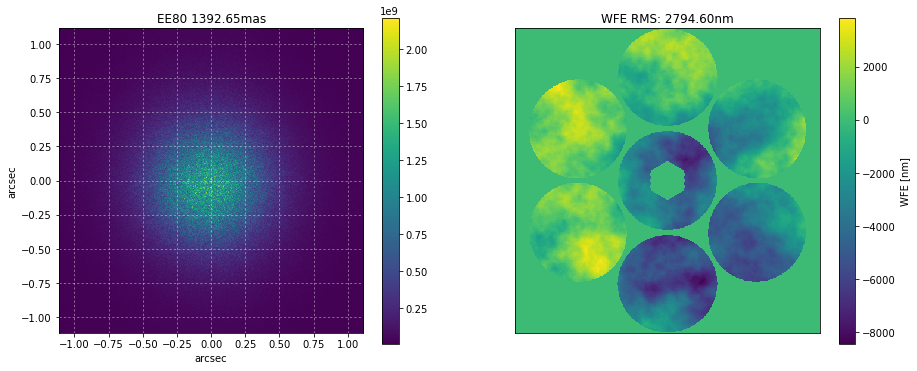

In [84]:
psf_atm_aco = imgr.frame.host()
ee80 = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,6)

fwhm8 = (gs0.wavelength/8)*ceo.constants.RAD2ARCSEC
o = np.linspace(0,1,21)*2*np.pi
x8 = 0.5*fwhm8*np.cos(o)
y8 = 0.5*fwhm8*np.sin(o)

ext = np.array([-1,1,-1,1])*imgr.N_PX_FRAME*0.5*imgr.pixelScaleArcsec(gs0)
h1 = ax1.imshow(psf_atm_aco,interpolation='none',cmap='viridis',extent=ext)
ax1.set_title("EE80 %.2fmas"%(ee80))
ax1.plot(x8,y8,'w:', linewidth=0.5)
ax1.grid(color='w',linestyle=':',alpha=0.5)
ax1.set_xlabel('arcsec')
ax1.set_ylabel('arcsec')
clb1 = plt.colorbar(h1,ax=ax1)

h2 = ax2.imshow(gs0.phase.host(units='nm'),interpolation='none',cmap='viridis')
clb2 = plt.colorbar(h2,ax=ax2,label='WFE [nm]')
ax2.set_title("WFE RMS: %.2fnm"%ps0_rms[k])
ax2.set_xticks([])
ax2.set_yticks([])


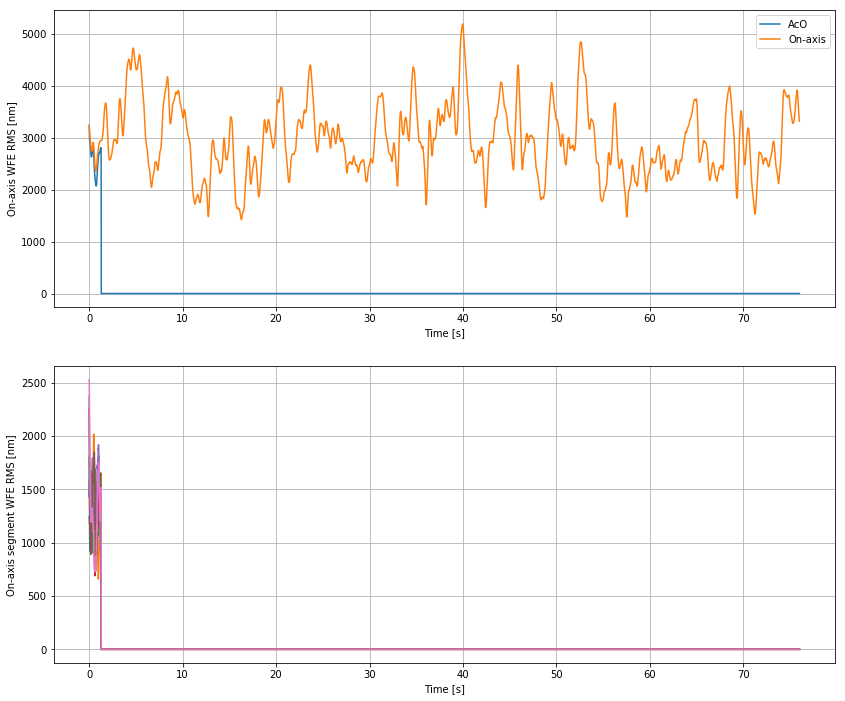

In [85]:
u = np.arange(nStep)*samplingTime
fig, (ax1,ax2) = plt.subplots(nrows=2)
fig.set_size_inches((14,12))
ax1.plot(u,ps0_rms.ravel(),label='AcO')
ax1.plot(u,ps0_rms_0.ravel(),label='On-axis')
ax1.grid()
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('On-axis WFE RMS [nm]')
ax1.legend(loc='best')

ax2.plot(u,ps0_seg_rms,label='AcO')
ax2.grid()
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('On-axis segment WFE RMS [nm]')

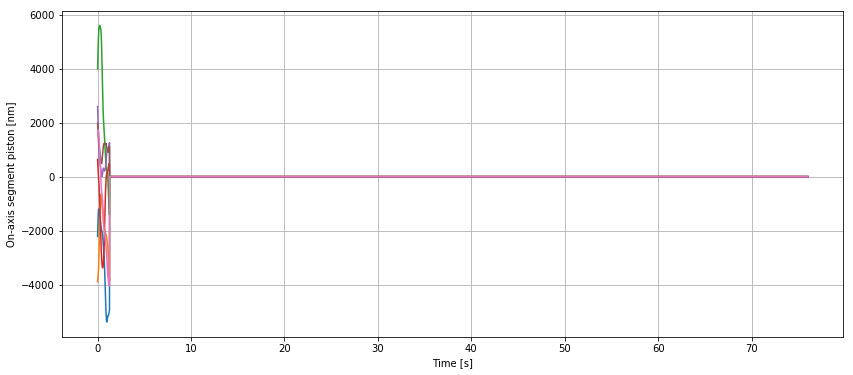

In [86]:
fig, ax1 = plt.subplots()
fig.set_size_inches((14,6))
ax1.plot(u,ps0_seg_piston,label='AcO')
#ax1.plot(u,ps0_rms_0.ravel(),label='On-axis')
ax1.grid()
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('On-axis segment piston [nm]')

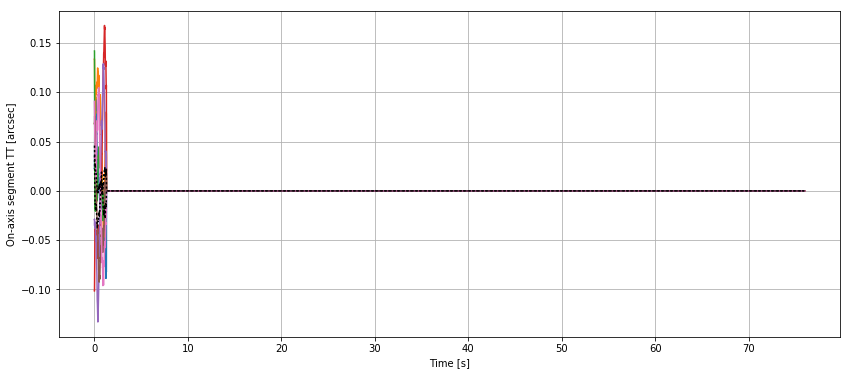

In [91]:
fig = plt.figure(figsize=(14,6))
#stt_ = np.concatenate(stt,axis=1).T
plt.plot(u,stt[:,:7],'-')
plt.plot(u,gtt,'k:')
#plt.plot([0,45],np.tile(tt7.reference_slopes[:,0].T*ceo.constants.RAD2ARCSEC,2).reshape(2,14))
#plt.xlim([0,45])
#plt.ylim([-0.1,0.1])
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('On-axis segment TT [arcsec]')

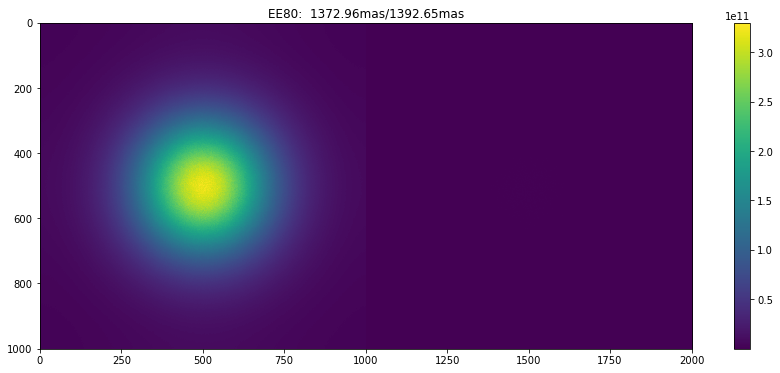

In [92]:
fig,ax1 = plt.subplots()
fig.set_size_inches(15,6)
h1 = ax1.imshow(np.concatenate([psf_atm_0,psf_atm_aco],axis=1),interpolation='none',cmap='viridis')
ax1.set_title("EE80:  %.2fmas/%.2fmas"%(ee80_atm_0,ee80))
plt.colorbar(h1,ax=ax1)
#ax1.set_xticks([])
#ax1.plot(x8,y8,'w:')


In [93]:
print "Reference PSF flux: %g"%np.sum(psf_atm_0)
print "AcO PSF flux      : %g"%np.sum(psf_atm_aco)

Reference PSF flux: 4.75161e+16
AcO PSF flux      : 1.77251e+14


In [94]:
PSSN = np.sum(psf_atm_aco**2)/np.sum(psf_atm_0**2)
print "PSSN = %f"%PSSN

PSSN = 0.000015


In [97]:
np.savez('AcO_Ctrl.npz',PSSN=PSSN,WFE_RMS_0=ps0_rms_0.ravel(),WFE_RMS=ps0_rms.ravel(),
                        SEGMENT_WFE_RMS=ps0_seg_rms,SEGMENT_WFE_PISTON=ps0_seg_piston,
                        PSF_0=psf_atm_0,PSF=psf_atm_aco,
                        EE80_0 = ee80_atm_0, EE80=ee80,
                        segment_tipTilt = stt,
                        global_tipTilt = gtt,
                        BM_coefficients = bmc,
                        last_wavefront_nm=gs0.phase.host(units='nm'))

In [59]:
from scipy.signal import medfilt

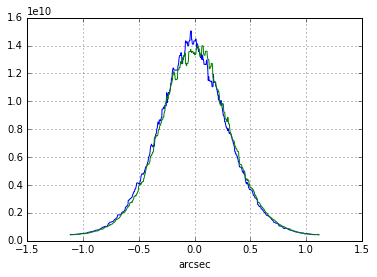

In [60]:
kern = 11
plt.plot(np.linspace(-1,1,imgr.N_PX_FRAME)*imgr.pixelScaleArcsec(gs0)*imgr.N_PX_FRAME*0.5,medfilt(psf_atm_0[:,500],kern))
plt.plot(np.linspace(-1,1,imgr.N_PX_FRAME)*imgr.pixelScaleArcsec(gs0)*imgr.N_PX_FRAME*0.5,medfilt(psf_atm_aco[:,500],kern))
plt.grid()
plt.xlabel('arcsec')


In [61]:
from twilio.rest import TwilioRestClient

# Find these values at https://twilio.com/user/account
account_sid = "ACc974b7f06c6738c383a4a79460c93ec4"
auth_token = "068f6f9a52798b5965c7d24ddc620b97"
client = TwilioRestClient(account_sid, auth_token)

message = client.messages.create(to="+16263548207", from_="+16266583114",
                                     body="ACO CTRL SIMULATION ENDED (PSSN=%.4f)"%PSSN)
